In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_moons
from sklearn.metrics import accuracy_score

AMOUNT_SAMPLES = 1000
TRAIN_PART = int(0.7*AMOUNT_SAMPLES)

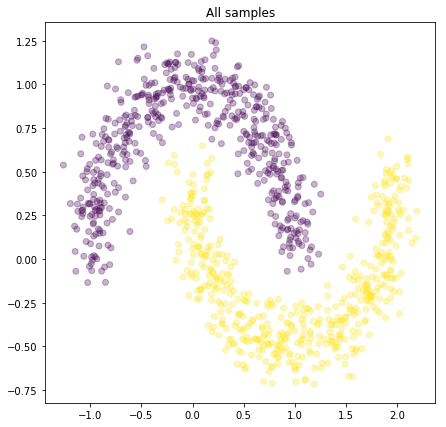

In [2]:
X, y = make_moons(n_samples=AMOUNT_SAMPLES, noise=0.12)
plt.figure(figsize=(7, 7))
plt.title('All samples')
plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.3)
plt.show()

X_train = X[:TRAIN_PART]
y_train = y[:TRAIN_PART]

X_test  = X[TRAIN_PART:]
y_test = y[TRAIN_PART:]

In [3]:
class ForwardNN():

    @staticmethod
    def softmax(u):
        exped = np.exp(u)
        partition = np.sum(exped, axis=1, keepdims=True)
        return exped / partition

    def __init__(self, input_size, hidden_size, output_size, alpha, lambda_reg):       
        self.alpha = float(alpha)
        self.rlambda = float(lambda_reg)
        
        self.W1 = np.random.randn(input_size, hidden_size) / np.sqrt(input_size)
        self.b1 = np.zeros((1, hidden_size))
        self.W2 = np.random.randn(hidden_size, output_size) / np.sqrt(hidden_size)
        self.b2 = np.zeros((1, output_size))
        
    def cost_function(self, X, y):
        """Returns the J cost of the neural network based on its predictions."""
        
        n = X.shape[0]
        self.forward_prop(X)

        # J = (loss caused by misclassifications) + (weights regularization)
        J = -np.sum(np.log(self.a3[np.arange(n), y])) + \
            self.rlambda/2 * (np.sum(np.square(self.W1)) + np.sum(np.square(self.W2)))
        return J/n

    def forward_prop(self, X):
        """Performs just the forward pass on the network with X samples."""
        
        self.a1 = X
        self.z2 = self.a1.dot(self.W1) + self.b1
        self.a2 = np.tanh(self.z2)
        self.z3 = self.a2.dot(self.W2) + self.b2
        self.a3 = self.softmax(self.z3)
        
    def predict(self, X):
        """Predicts to which class the samples in X belong to."""
        
        self.forward_prop(X)
        return np.argmax(self.a3, axis=1)
    
    def back_prop(self, y):
        """Computes the gradients wrt. each parameter on the network. Doesn't update them."""
        
        n = y.shape[0]
        self.d3 = self.a3
        self.d3[np.arange(n), y] -= 1

        self.dW2 = self.a2.T.dot(self.d3) + self.rlambda * self.W2
        self.db2 = np.sum(self.d3, axis=0, keepdims=True)
        
        self.d2 = self.d3.dot(self.W2.T) * (1 - np.power(self.a2, 2))
        self.dW1 = self.a1.T.dot(self.d2) + self.rlambda * self.W1
        self.db1 = np.sum(self.d2, axis=0, keepdims=True)
        
    def gradient_step(self):
        """Updates the weights based on the values obtained with back_prop."""
        
        self.W2 -= self.alpha * self.dW2
        self.b2 -= self.alpha * self.db2
        self.W1 -= self.alpha * self.dW1
        self.b1 -= self.alpha * self.db1
        
    def backprop_step(self, y):
        """Shorthand method to compute the gradients and update the weights."""
        
        self.back_prop(y)
        self.gradient_step()
        
    def fit(self, X, y, epochs, interval_loss):
        """Trains the networks using *full* batch gradient descent."""

        losses = list()
        loss_on = list()
        
        print('Initial cost: {:4.4}'.format(self.cost_function(X, y)))
        for i in range(epochs):
            self.forward_prop(X)
            self.backprop_step(y)
            
            if i % interval_loss == 0:
                losses.append(self.cost_function(X, y))
                loss_on.append(i)
            
        print('Final cost:   {:4.4}'.format(self.cost_function(X, y)))
        
        return loss_on, losses
        
    def gradient_check(self, x, y, h=0.001, epsilon=0.01):
        
        # Gradient values are cached internally as object members
        self.forward_prop(x)
        self.backprop_step(y)
        
        for param, grad in zip(['W1', 'W2'], ['dW1', 'dW2']):
            W = self.__getattribute__(param)
            dW = self.__getattribute__(grad)
            
            it = np.nditer(W, flags=['multi_index'], op_flags=['readwrite'])
            while not it.finished:
                indices = it.multi_index
                original_w = W[indices]
                w_gradient = dW[indices]
                
                # estimating the gradient
                W[indices] = original_w + h
                w_plus = self.cost_function(x, y)
                
                W[indices] = original_w - h
                w_minus = self.cost_function(x, y)
                
                W[indices] = original_w
                w_estimated = (w_plus - w_minus) / (2*h)
                
                error = np.abs(w_estimated - w_gradient) /
                        (np.abs(w_estimated) + np.abs(w_gradient))
                if error > epsilon:
                    print('[WARN] Gradient check failed for ' +
                          'parameter {}[{}, {}]'.format(param,
                                                        it.multi_index[0],
                                                        it.multi_index[1]))
                    print('[WARN] Expected {:4.4}, got {:4.4}. ' +
                          'Epsilon is {:0.4}'.format(w_estimated,
                                                     w_gradient,                                                     epsilon))
                
                it.iternext()
            print('[INFO] Gradient checking OK for parameter {}'.format(param))
                
    def __str__(self):
        s1 = 'Input:  {}\nHidden: {}\nOutput: {}\n'.format(self.W1.shape[0],
                                                           self.W1.shape[1],
                                                           self.W2.shape[1])
        s2 = 'Alpha  = {:4.4}\nLambda = {:4.4}\n'.format(self.alpha, self.rlambda)
        s3 = 'W1 -> {}\nW2 -> {}\ny  ->  {}\n'.format(self.W1.shape, self.W2.shape,
                                                      self.W2.shape[1])
        return s1 + s2 + s3

In [4]:
# Neural Network architecture and hyperparameters

n_features = 2
n_hidden   = 3
n_output   = 2

alpha      = 0.005
lambda_reg = 1e-4
epochs     = 800

# Creating a NN and checking if its backprop is working fine
nn = ForwardNN(n_features, n_hidden, n_output, alpha, lambda_reg)
nn.gradient_check(X_train[0][None], y_train[0][None], epsilon=0.05)

[INFO] Gradient checking OK for parameter W1
[INFO] Gradient checking OK for parameter W2


Initial cost: 0.777
Final cost:   0.002182
Accuracy on test set:  1.0


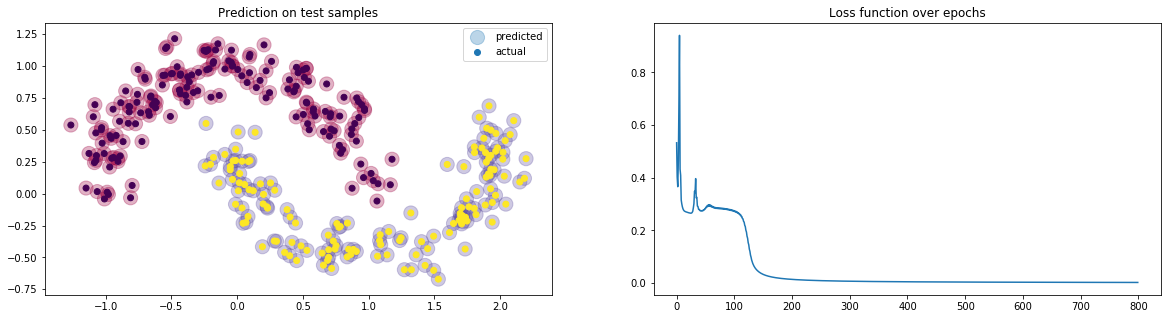

In [5]:

# Training
epochno, losses = nn.fit(X_train, y_train, epochs, 1)

# Visualization
y_hat = nn.predict(X_test)
print('Accuracy on test set: {:4.4}'.format(accuracy_score(y_test, y_hat)))


# Plotting
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.title('Prediction on test samples')
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_hat, alpha=0.3,
            cmap=plt.cm.Spectral, s=200, label='predicted')
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, alpha=1,
            label='actual')
plt.legend()

plt.subplot(122)
plt.title('Loss function over epochs')
plt.plot(epochno, losses)

plt.legend()
plt.show()